# Braindecode CNN training and prediction 
This notebook loads epoched dataframes and trains a braindecode models on the two possible classes. Both trialwise and cropped are implemented. Saving the models is easy and can be imported to a different notebook for further analysis. 

In [1]:
%matplotlib inline
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import getSEM, getCleanedSignal, getIntervals, getPowerRatio
import pandas as pd

from featureBuilder import featureBuilder
import random, time

random.seed(1)

import warnings
warnings.filterwarnings("ignore")




In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Import svm model
from sklearn import svm


In [3]:
from braindecode.datautil.signal_target import SignalAndTarget

from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from torch import nn
from braindecode.torch_ext.util import set_random_seeds

from braindecode.torch_ext.optimizers import AdamW

import torch.nn.functional as F


In [4]:
def zipShuffle(A, B):
    C = list(zip(A, B))
    random.shuffle(C)
    A, B = zip(*C)
    return np.array(A), np.array(B)


In [5]:
def getStateDF(df):
    # Select the trials needed to classify
    focused_state = df["trial_time"] == 0.7
    unfocused_state = df["trial_time"] > 0.9
    med_state = ((df["trial_time"] > 0.7) & (df["trial_time"] <= 0.9))

    focused_df = df[focused_state]
    unfocused_df = df[unfocused_state]
    med_df = df[med_state]
    
    return focused_df, unfocused_df, med_df

In [6]:
def getTrials(original_data, original_time, df, trial_length=500, sample_per=10): 
    """
    original_data : eeg data
    original_time : time data
    df : dataframe containing the corresponding times with original_time for trial_time extraction
    trial_length : number of timepoints desired in each eeg_data
    sample_per : sample every this number of timepoints
    """
    if len(original_data) != len(original_time):
        print("length of original data and time must be the same!")
        return [], []
    
    actual_focus = []
    eeg_data = []
    prev_df_time = 0
    num_timepoints = len(original_data)
    for i in range(num_timepoints): 
        if (i > trial_length) and (i % sample_per == 0): 
            current_time = original_time[i]
            eeg = original_data[i-trial_length: i]
            elem = df[(df['time'] <= current_time) & (df['time'] >= prev_df_time)]
            if len(elem) > 0: 
                #print(len(elem))
                elem = elem.iloc[-1]
                actual_focus.append(1 if elem['trial_time'] <= 0.7 else 0 if elem['trial_time'] <= 0.9 else -1)
                eeg_data.append(eeg)
                prev_df_time = elem['time']
            else :
                print("no df")
    return actual_focus, eeg_data

In [180]:
def shuffleAndBalance(X, y, values_to_keep):
    """ X is input, y is label containing (-1, 0, 1)
    """
    X, y = zipShuffle(X, y)        
    num_per_type = min([list(y).count(val) for val in values_to_keep])
    dictionary = {} 
    for i, val in enumerate(y): 
        if val in values_to_keep: 
            if val not in dictionary : 
                dictionary[val] = []
            dictionary[val].append(X[i])

    X = []
    y = []
    for key in dictionary:
        X.extend(dictionary[key][:num_per_type])
        y.extend([key]*num_per_type)

    X, y = zipShuffle(X, y)
    X = list(X)
    y = list(y)
    return X, y

## Build dataframes and variables needed for continuous training

In [225]:
foldername="P001"
filenames = ["part_P001_block_S004", "part_P001_block_S005"]#, "part_P001_block_S006"]
actual_focus = []
eeg_data = []
for filename in filenames: 
    # If using filtered data
    path = "../data/filtered_data/"+foldername+"/"+filename+".pickle"
    loaded_data = loadPickle(path)#loadxdf(path)

    # If using XDF data
    # XDF_Path = "../data/XDF_data/"+foldername+"/"+filename+".xdf"
    # XDF_Data = loadxdf(XDF_Path)
    #loaded_data = epochByMarkIndex(0, -1, XDF_Data)
    df = loadData(datatype='dataframe', foldername=foldername, filename=filename)

    ## Get trials
    article_data = getArticleSectionData("response", 0, loaded_data)
    loaded_eeg_data = article_data['eeg']['data']
    loaded_eeg_time = article_data['eeg']['time']

    focus_values, eeg = getTrials(loaded_eeg_data, loaded_eeg_time, df, trial_length=500, sample_per=20 )
    
    actual_focus.extend(focus_values)
    eeg_data.extend(eeg)
    
    article_data = getArticleSectionData("response", 1, loaded_data)
    loaded_eeg_data = article_data['eeg']['data']
    loaded_eeg_time = article_data['eeg']['time']

    focus_values, eeg = getTrials(loaded_eeg_data, loaded_eeg_time, df, trial_length=500, sample_per=20 )
    
    actual_focus.extend(focus_values)
    eeg_data.extend(eeg)


In [226]:
# Shuffle 
X, y = shuffleAndBalance(eeg_data, actual_focus, (-1, 1))

print("num_focused:", y.count(1))
print("num_unfocused:", y.count(-1))
print("num_med:", y.count(0))

y = np.array([1 if i == 1 else 0 for i in y])
X = np.array([np.transpose(X[i]) for i in range(len(X))])
# X = X[:, [0, 1, 6, 7], :]

num_focused: 3746
num_unfocused: 3746
num_med: 0


In [227]:
# Split data up
percent_train = 0.7
num_train = int(len(X) * percent_train)
percent_valid = 0.2
num_valid = int(len(X) * percent_valid)

train_set = SignalAndTarget(X[:num_train], y[:num_train])
valid_set = SignalAndTarget(X[num_train:num_train + num_valid], y[num_train:num_train + num_valid])
test_set = SignalAndTarget(X[num_train + num_valid:], y=y[num_train + num_valid:])
whole_set = SignalAndTarget(X, y)

## Build dataframes and variables needed for trialwise training

In [ ]:
# Load data from memory
foldername='P001'
filename='part_P001_block_S004'
#filtered_data = loadData(datatype='filtered_data', foldername=foldername, filename=filename)
#filtered_cleaned_data = loadData(datatype='filtered_cleaned_data', foldername=foldername, filename=filename)
df = loadData(datatype='dataframe_filtered', foldername=foldername, filename=filename)


In [ ]:
# Load data from memory
foldername='P001'
filename='part_P001_block_S005'
#filtered_data = loadData(datatype='filtered_data', foldername=foldername, filename=filename)
#filtered_cleaned_data = loadData(datatype='filtered_cleaned_data', foldername=foldername, filename=filename)
df2 = loadData(datatype='dataframe_filtered', foldername=foldername, filename=filename)


In [ ]:
focused_df, unfocused_df, med_df = getStateDF(df)
focused_df2, unfocused_df2, med_df2 = getStateDF(df2)

In [ ]:
focused_df = focused_df.append(focused_df2)
unfocused_df = unfocused_df.append(unfocused_df2)

In [ ]:
# Create lists of just the epochs and corresponding focus level
data_type = "data_extended"
focused_epochs = []
focused_y = []

for idx, row in focused_df.iterrows(): 
    focused_epochs.append(np.array(row[data_type][StreamType.EEG.value][StreamType.DATA.value]))
    focused_y.append(1)

unfocused_epochs = []
unfocused_y = []
for idx, row in unfocused_df.iterrows(): 
    unfocused_epochs.append(np.array(row[data_type][StreamType.EEG.value][StreamType.DATA.value]))
    unfocused_y.append(0)
    
print("focused:", len(focused_y), "unfocused:", len(unfocused_y))
    

In [ ]:
# Make the two sets the same length
focused_epochs = tidyEEGList(np.array(focused_epochs))
unfocused_epochs = tidyEEGList(np.array(unfocused_epochs))

focused_epochs, focused_y = zipShuffle(focused_epochs, focused_y)
unfocused_epochs, unfocused_y = zipShuffle(unfocused_epochs, unfocused_y)

num_per_type = min(len(focused_y), len(unfocused_y))

focused_epochs, focused_y = focused_epochs[:num_per_type], focused_y[:num_per_type]
unfocused_epochs, unfocused_y = unfocused_epochs[:num_per_type], unfocused_y[:num_per_type]

In [ ]:
# Create X and y matrices 
X = np.array(list(focused_epochs) + list(unfocused_epochs))
y = np.array(list(focused_y) + list(unfocused_y))

X = tidyEEGList(X)

# Trim to 500 timepoints if possible
if X.shape[1] >= 500: 
    X = X[:, :500, :]
else: 
    print("shape of X is too smalle to be trimmed")

X = np.array([np.transpose(X[i]) for i in range(len(X))])

X, y = zipShuffle(X, y)
len(y)

In [ ]:
# Split data up
percent_train = 0.7
num_train = int(len(X) * percent_train)
percent_valid = 0.2
num_valid = int(len(X) * percent_valid)

train_set = SignalAndTarget(X[:num_train], y[:num_train])
valid_set = SignalAndTarget(X[num_train:num_train + num_valid], y[num_train:num_train + num_valid])
test_set = SignalAndTarget(X[num_train + num_valid:], y=y[num_train + num_valid:])
whole_set = SignalAndTarget(X, y)

## Model Visualization

In [118]:
import torch 
model = torch.load("models/model_t_combined_continuous_filtered.pickle")

In [260]:
# Create the dataframes
x_values = whole_set.X
pred = model.predict_classes(x_values)



In [261]:
to_vis_x, to_vis_y = shuffleAndBalance(x_values, pred, (0, 1))
to_vis_x, to_vis_y = np.array(to_vis_x), np.array(to_vis_y)


In [236]:
to_vis_x, to_vis_y = x_values, pred


In [262]:
fb = featureBuilder()
dictionary = {}

for idx in range(len(to_vis_y)):
    eeg_data = to_vis_x[idx, 6:8]
    dictionary = fb.appendEEGDataToDict(eeg_data, 250, focused=to_vis_y[idx], dictionary=dictionary)
# keywords_to_keep = ['delta', 'theta', 'alpha', 'beta', 'focused']
# dkeys = list(dictionary.keys())
# for key in dkeys: 
#     if not any(word in key for word in keywords_to_keep):
#         del dictionary[key]
feature_df = pd.DataFrame(dictionary)
len(feature_df)

4468

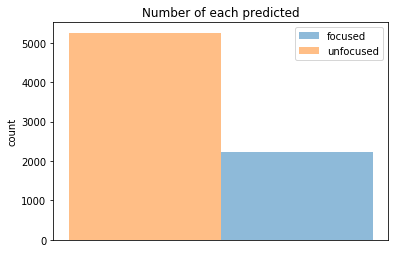

In [263]:
plt.hist([1]*list(pred).count(1), bins=1, alpha=0.5, label="focused")
plt.hist([0]*list(pred).count(0), bins=1, alpha=0.5, label="unfocused")
plt.legend()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are offplt.title("")
plt.ylabel("count")
plt.title("Number of each predicted")
plt.show()

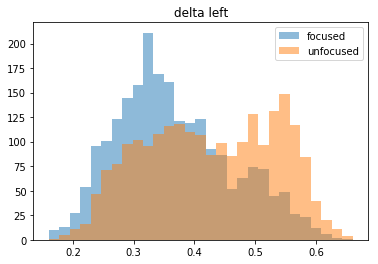

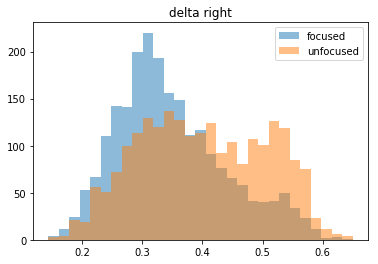

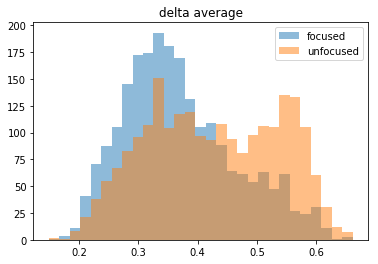

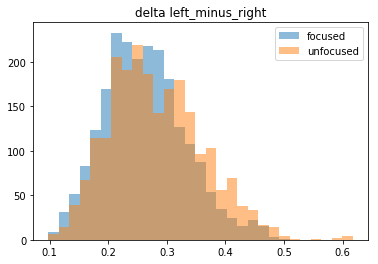

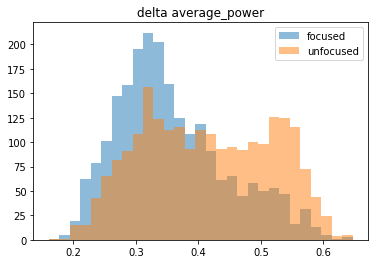

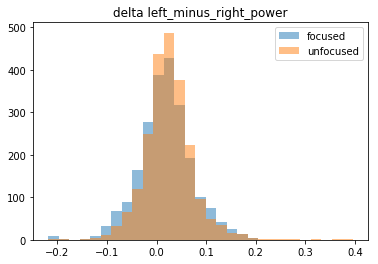

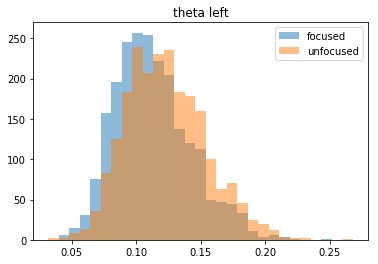

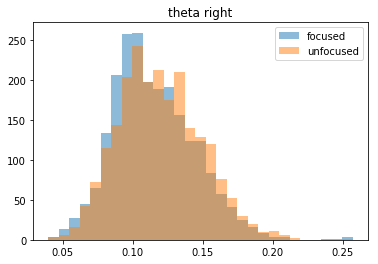

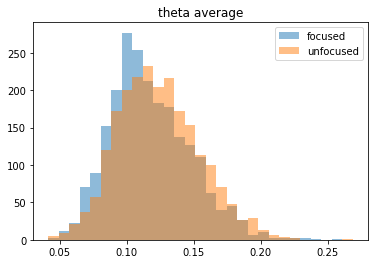

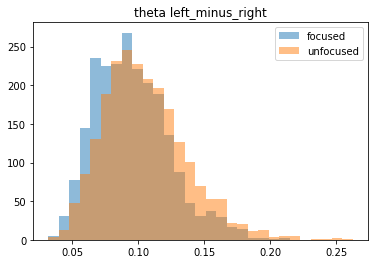

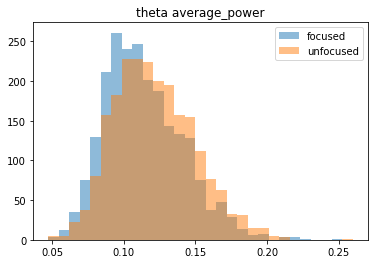

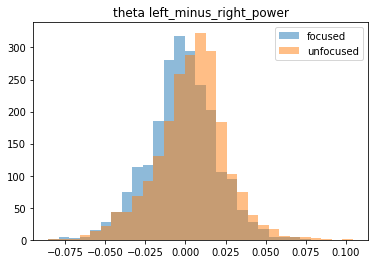

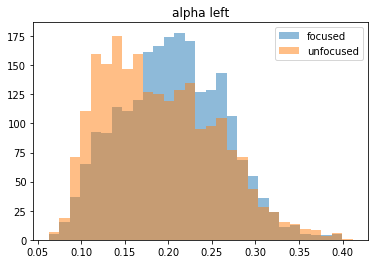

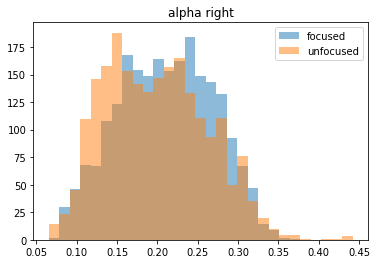

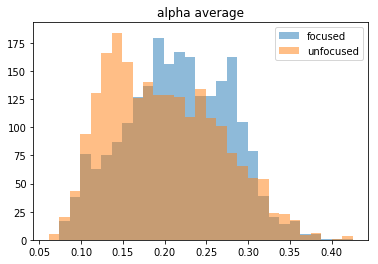

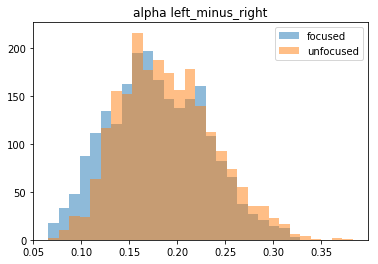

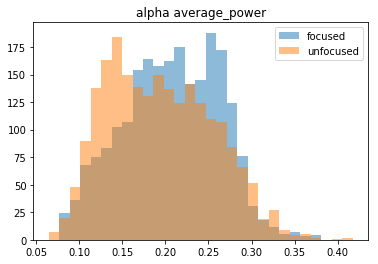

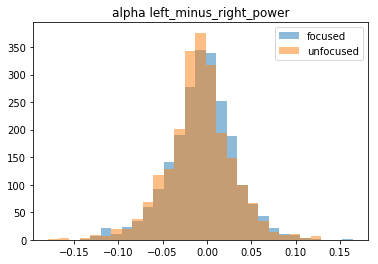

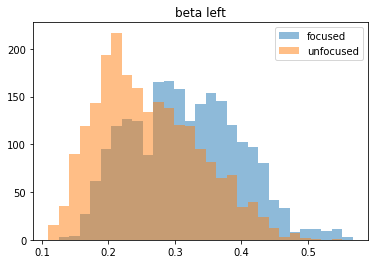

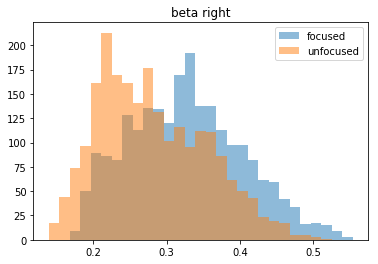

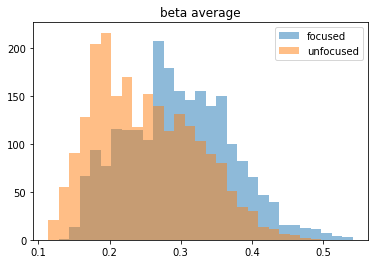

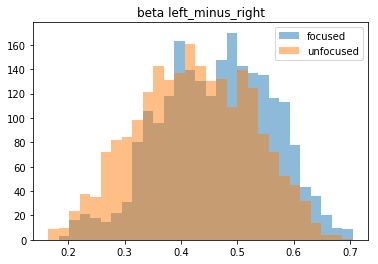

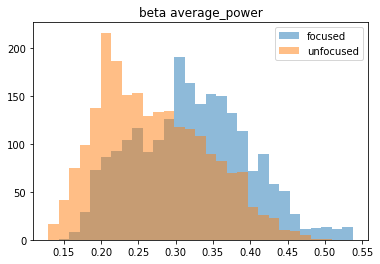

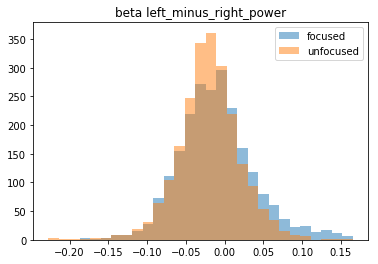

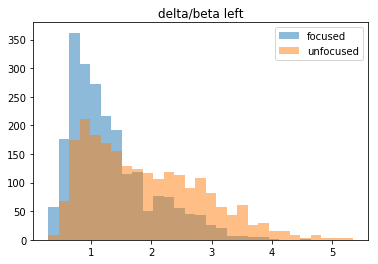

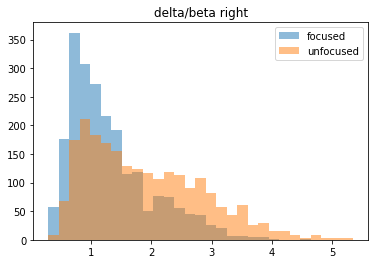

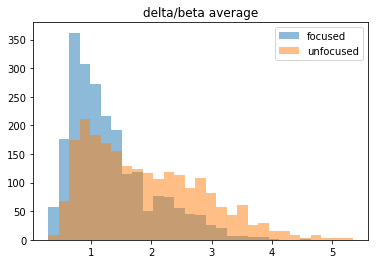

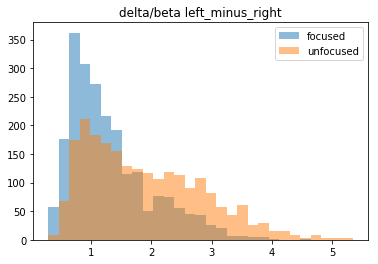

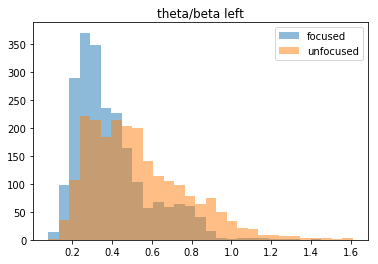

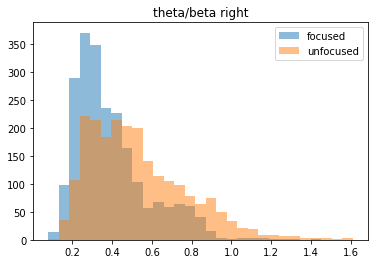

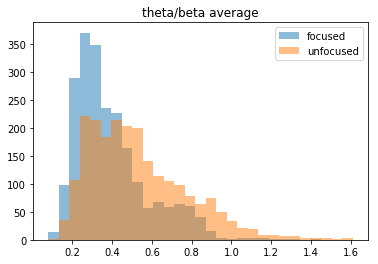

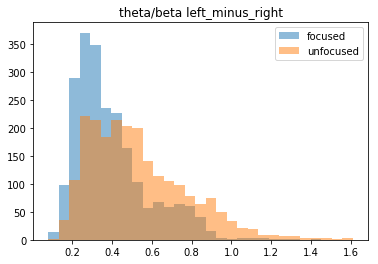

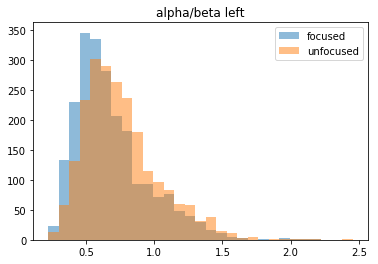

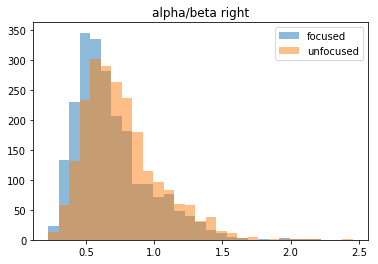

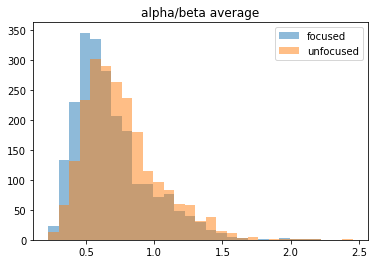

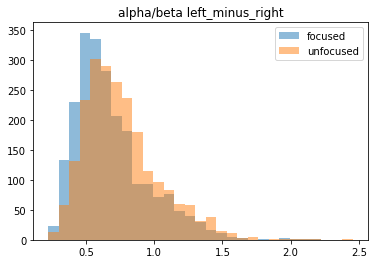

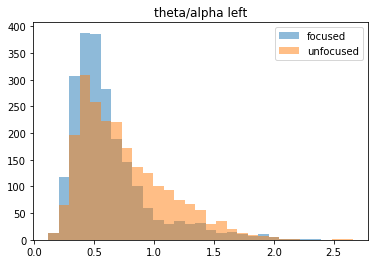

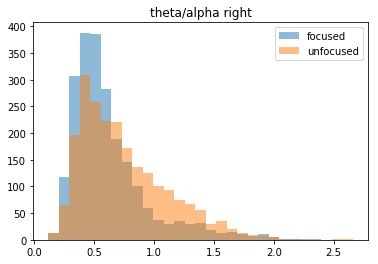

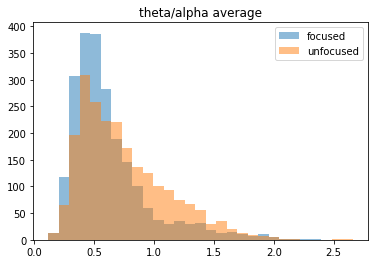

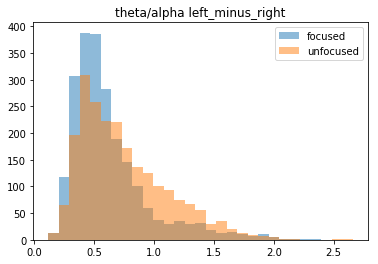

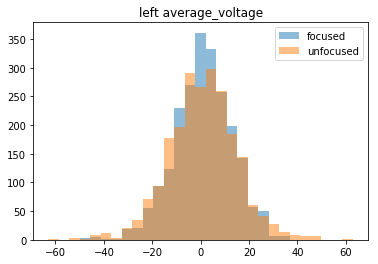

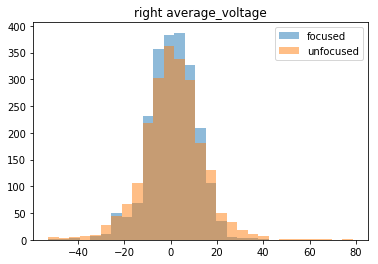

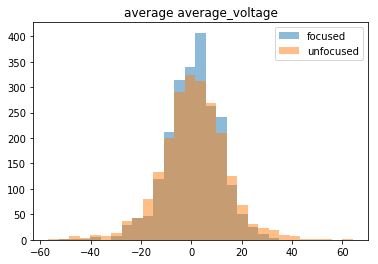

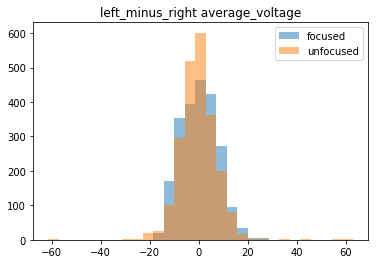

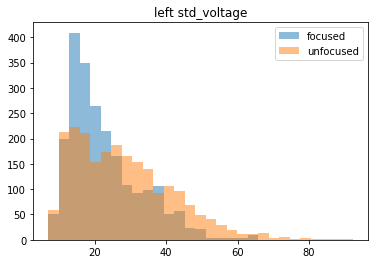

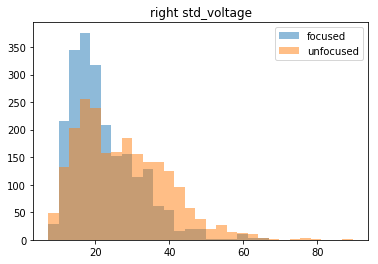

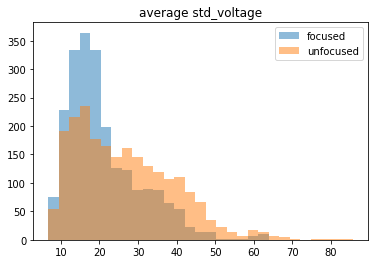

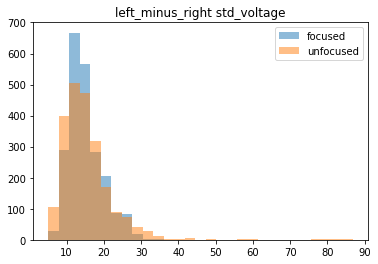

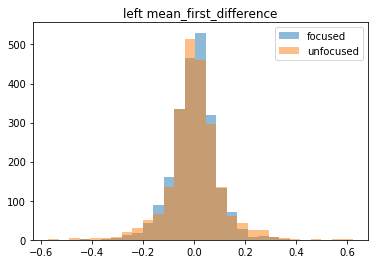

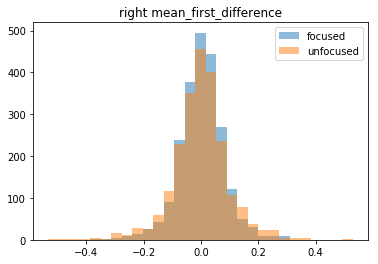

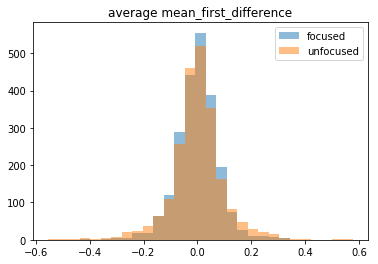

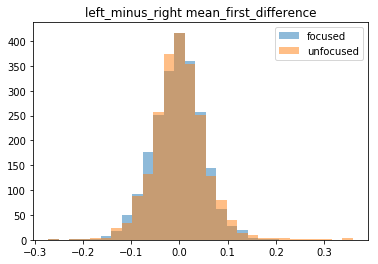

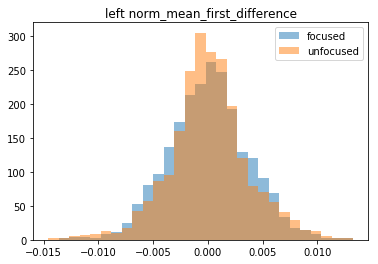

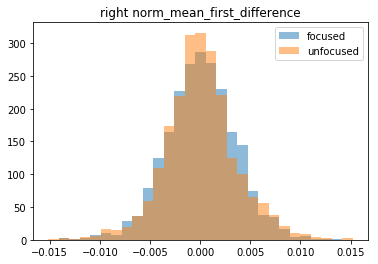

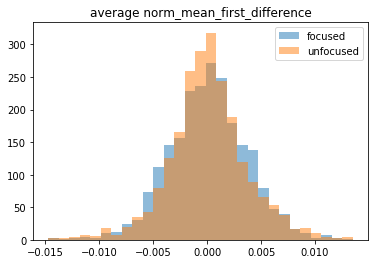

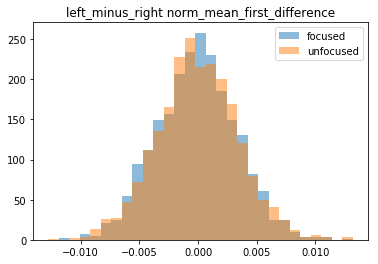

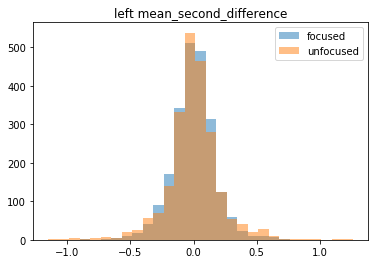

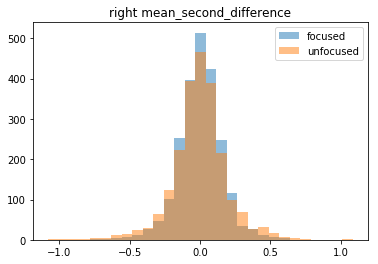

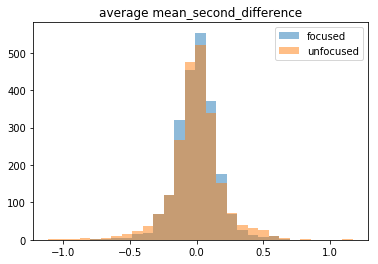

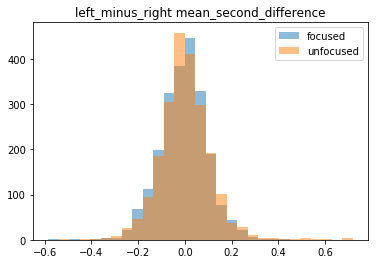

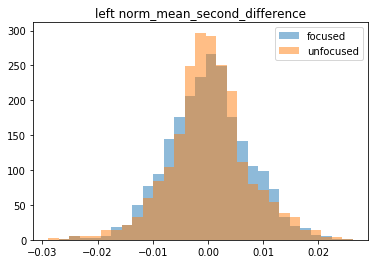

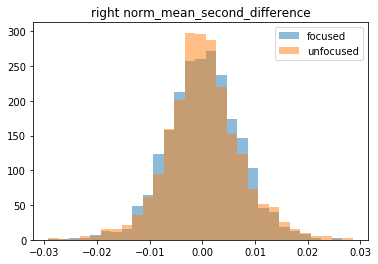

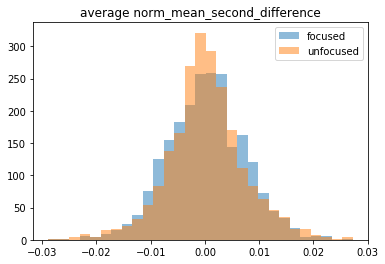

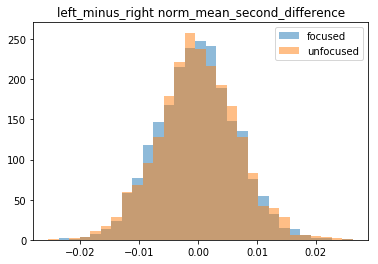

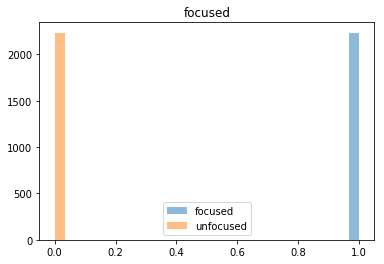

In [264]:
for col in feature_df.columns: 
    full_data = feature_df[col].values
    bins = np.linspace(min(full_data), max(full_data), 30)
    
    data = feature_df[feature_df['focused'] == 1][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="focused") 
    
    data = feature_df[feature_df['focused'] == 0][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="unfocused") 
    
   
    plt.title(col)
    plt.legend()
    plt.show()

In [239]:
# Needed for visualizing LDA components
colors=['orange', 'blue']
class_names=["unfocused", "focused"]


In [240]:
# Average the accuracy over X different random samples
accuracies = []
for rand_state_var in range(10): 
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df.drop(columns=["focused"]), feature_df["focused"], test_size=0.2, random_state=rand_state_var)

    lda = LinearDiscriminantAnalysis(n_components=1)
    features_wo_output = feature_df.drop(columns=["focused"])
    X_train, scaler = scaleData(X_train, X_train.columns.values) # Scaling doesn't change anything
    X_test = scaler.transform(X_test)
    X_train = lda.fit_transform(X_train, y_train)
    
    z_labels = lda.predict(X_test) #gives you the predicted label for each sample
    z_prob = lda.predict_proba(X_test) #the probability of each sample to belong to each class
    #Predict the response for test dataset
    y_pred = z_labels
    X_test = lda.transform(X_test)

    # Report accuracy
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    print('Accuracy', str(accuracy_score(y_test, y_pred)))
    accuracies.append(accuracy_score(y_test, y_pred))
print("Avg LDA accuracy:", np.mean(np.array(accuracies)))
print("\n")
zipped_list = list(zip(lda.coef_[0], feature_df.drop(columns="focused").columns))
sorted_zip_list = sorted(zipped_list)
for elem in sorted_zip_list[:10]:
    print(elem)
print()
for elem in sorted_zip_list[-10:]:
    print(elem)

Accuracy 0.7258172114743162
Accuracy 0.7244829886591061
Accuracy 0.7384923282188125
Accuracy 0.7311541027351568
Accuracy 0.7418278852568378
Accuracy 0.7451634422948632
Accuracy 0.7391594396264176
Accuracy 0.7258172114743162
Accuracy 0.7224816544362909
Accuracy 0.7278185456971314
Avg LDA accuracy: 0.7322214809873249


(-24.240011639040954, 'right norm_mean_second_difference')
(-20.011692456863564, 'average norm_mean_first_difference')
(-18.642975237171726, 'left_minus_right mean_second_difference')
(-6.866650450354205, 'left mean_second_difference')
(-6.592181022969005, 'right std_voltage')
(-6.529580036050678, 'left norm_mean_second_difference')
(-5.823384948311824, 'beta average')
(-3.9627573395984568, 'left_minus_right norm_mean_first_difference')
(-2.8267579279952084, 'alpha average_power')
(-2.7402633415021223, 'alpha right')

(3.0034140355446453, 'right mean_second_difference')
(3.956106983375311, 'left norm_mean_first_difference')
(4.340602846687357, 'average std_voltage')
(5.253

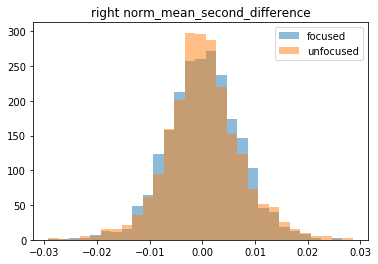

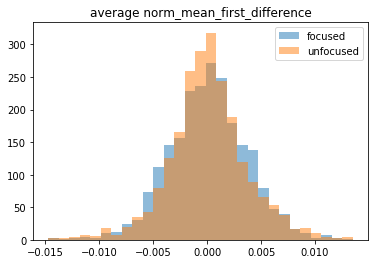

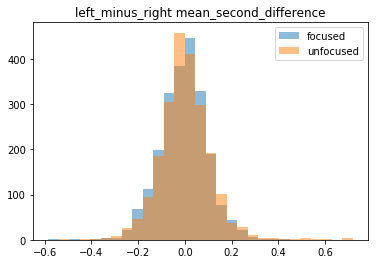

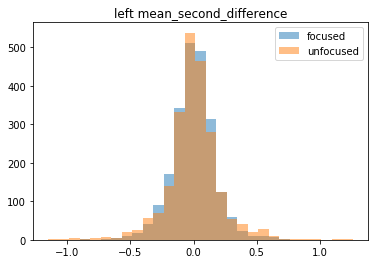

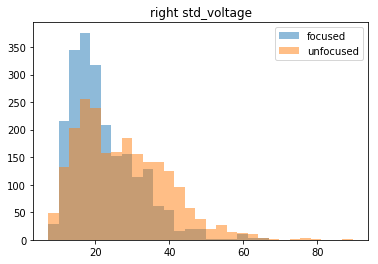

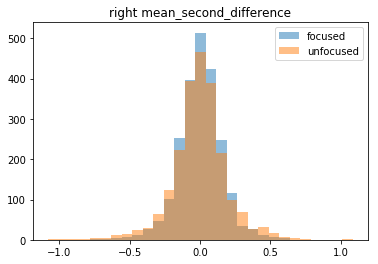

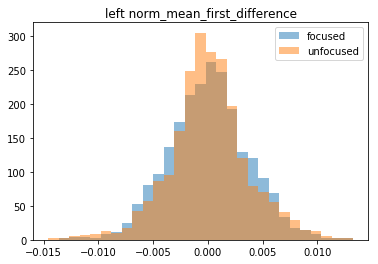

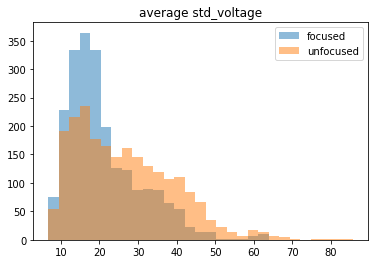

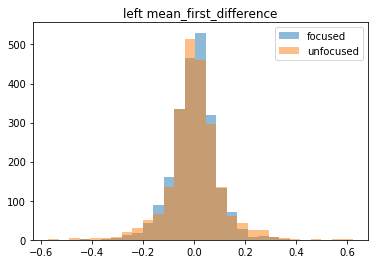

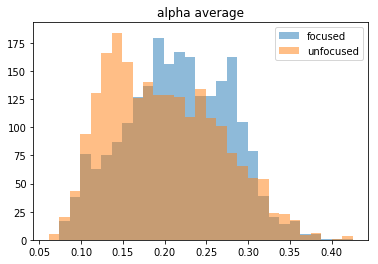

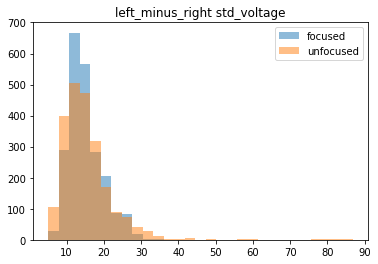

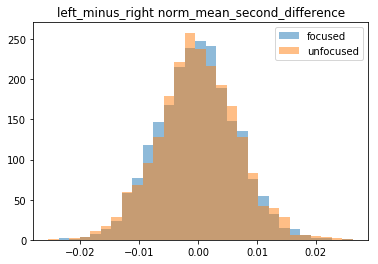

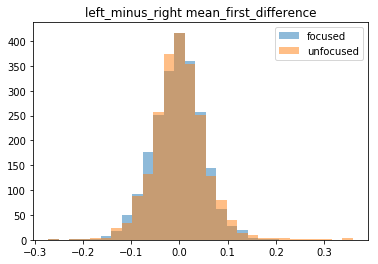

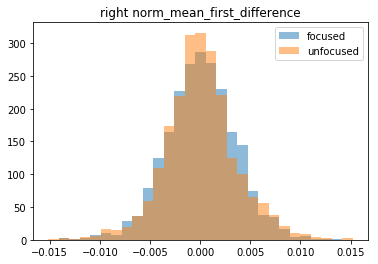

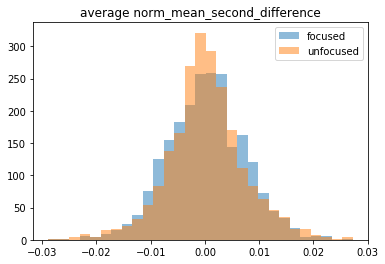

In [265]:
# Top most effective 

for elem in sorted_zip_list[:5]:
    col=elem[1]
    full_data = feature_df[col].values
    bins = np.linspace(min(full_data), max(full_data), 30)
    
    data = feature_df[feature_df['focused'] == 1][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="focused") 
    
    data = feature_df[feature_df['focused'] == 0][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="unfocused") 
    
   
    plt.title(col)
    plt.legend()
    plt.show()
print("==================================================")
for elem in sorted_zip_list[-10:]:
    col=elem[1]
    full_data = feature_df[col].values
    bins = np.linspace(min(full_data), max(full_data), 30)
    
    data = feature_df[feature_df['focused'] == 1][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="focused") 
    
    data = feature_df[feature_df['focused'] == 0][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="unfocused") 
    
   
    plt.title(col)
    plt.legend()
    plt.show()
    

LDA explained variance: [1.]


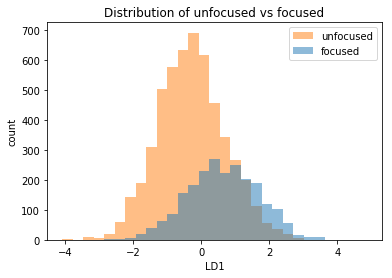

In [241]:
# Visualize LDA model 

class_names={1:"focused", 0:"unfocused"}
colors={1:"C0", 0:"C1"}
print("LDA explained variance:", lda.explained_variance_ratio_)

# Create dataframe for the feature
lda_feature_df = pd.DataFrame(np.concatenate([X_train, X_test]), columns=['LDA 1'])
lda_feature_df['focused']=np.concatenate([y_train.values, y_test.values])

# Plot groups wrt LDA 1 dimension
bins = np.linspace(min(lda_feature_df.values[:, 0]), max(lda_feature_df.values[:, 0]), 30)
for class_name, df in lda_feature_df.groupby('focused'): 
    plt.hist(df['LDA 1'].values, bins=bins, alpha=0.5,color=colors[class_name], label=class_names[class_name])

plt.xlabel('LD1')
plt.ylabel("count")
plt.title("Distribution of unfocused vs focused")    
plt.legend()
plt.show()

## Trialwise Decoding

In [42]:
train_set.X.shape

(5244, 8, 500)

In [43]:
# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
start_time = time.time()
cuda = False
set_random_seeds(seed=20170629, cuda=cuda)
n_classes = 2
in_chans = train_set.X.shape[1]
# final_conv_length = auto ensures we only get a single output in the time dimension
model_t = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes,
                        input_time_length=train_set.X.shape[2], 
                        #filter_time_length=4,
                        final_conv_length='auto')
if cuda:
    model_t.cuda()
    
#optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
optimizer = AdamW(model_t.parameters(), lr=0.0625 * 0.01, weight_decay=0)
model_t.compile(loss=F.nll_loss, optimizer=optimizer, iterator_seed=1)

model_t.fit(train_set.X, train_set.y, epochs=30, batch_size=64, scheduler='cosine',
         validation_data=(valid_set.X, valid_set.y))

end_time = time.time()
elapsed = end_time - start_time
print("time taken:", elapsed, "s")

time taken: 1426.4297580718994 s


In [44]:
model_t.epochs_df


,train_loss,valid_loss,train_misclass,valid_misclass,runtime
0,11.278347,30.355162,0.322082,0.872497,0.000000
1,0.719969,0.865606,0.367658,0.360481,44.097493
2,0.857201,1.443845,0.351068,0.537383,43.978966
3,0.833366,1.530789,0.323227,0.556075,46.473648
4,0.598786,1.171469,0.316934,0.819092,44.477473
5,0.733552,1.500915,0.305492,0.605474,45.203791
6,0.619090,0.714122,0.372044,0.341121,48.524132
7,0.671511,0.944060,0.359268,0.493324,46.470556
8,0.586785,1.141074,0.326468,0.851802,48.075234
9,0.737874,1.558823,0.303585,0.602136,47.540768


In [45]:
test_set = SignalAndTarget(X[70:], y=y[70:])

model_t.evaluate(test_set.X, test_set.y)

{'loss': 0.6776947379112244,
 'misclass': 0.4492050660199407,
 'runtime': 0.0006389617919921875}

In [46]:
pred_train_y = model_t.predict_classes(train_set.X)

sum(train_set.y == pred_train_y) / len(pred_train_y)



0.7067124332570557

In [47]:
pred_valid_y = model_t.predict_classes(valid_set.X)

sum(valid_set.y == pred_valid_y) / len(pred_valid_y)

0.22830440587449932

In [48]:
pred_test_y = model_t.predict_classes(test_set.X)

sum(test_set.y == pred_test_y) / len(pred_test_y)

0.5507949339800593

In [55]:
# import torch
# torch.save(model_t, "model_t_combined_continuous_unfiltered.pickle")
# torch.save(model_c, "model_c_combined_continuous_unfiltered.pickle")
# print("saved")

saved


## Cropped Decoding

In [49]:
# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.

start_time = time.time()
cuda = False
set_random_seeds(seed=20170629, cuda=cuda)
n_classes = 2
in_chans = train_set.X.shape[1]
# final_conv_length = auto ensures we only get a single output in the time dimension
model_c = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes,
                        input_time_length=None, 
                        final_conv_length=12)
if cuda:
    model_c.cuda()
    
#optimizer = AdamW(model.parameters(), lr=1*0.01, weight_decay=0.5*0.001) # these are good values for the deep model
optimizer = AdamW(model_c.parameters(), lr=0.0625 * 0.01, weight_decay=0)
model_c.compile(loss=F.nll_loss, optimizer=optimizer,  iterator_seed=1, cropped=True)

input_time_length = train_set.X.shape[2]
model_c.fit(train_set.X, train_set.y, epochs=30, batch_size=64, scheduler='cosine',
          input_time_length=input_time_length,
         validation_data=(valid_set.X, valid_set.y),)

end_time = time.time()
elapsed = end_time - start_time
print("time taken:", elapsed, "s")

time taken: 2759.4721071720123 s


In [50]:
model_c.epochs_df

,train_loss,valid_loss,train_misclass,valid_misclass,runtime
0,11.100625,2.028305,0.677918,0.127503,0.000000
1,0.614819,1.150714,0.319031,0.621495,84.703264
2,0.714676,1.154933,0.343059,0.536716,88.884862
3,0.658973,1.386534,0.318459,0.643525,89.727529
4,0.579723,0.920546,0.322082,0.872497,85.267558
5,0.624045,1.376155,0.322082,0.872497,91.995783
6,0.620330,0.974865,0.351449,0.565421,89.229419
7,0.592095,1.157657,0.322082,0.872497,86.827777
8,0.582069,0.777336,0.360603,0.520027,98.858296
9,0.603780,1.147183,0.315599,0.649533,89.189300


In [51]:
test_set = SignalAndTarget(X[70:], y=y[70:])

model_c.evaluate(test_set.X, test_set.y)

{'loss': 0.676242470741272,
 'misclass': 0.4465103745621126,
 'runtime': 0.0005047321319580078}

In [52]:
pred_train_y = model_c.predict_classes(train_set.X)

sum(train_set.y == pred_train_y) / len(pred_train_y)

0.6910755148741419

In [53]:
pred_valid_y = model_c.predict_classes(valid_set.X)

sum(valid_set.y == pred_valid_y) / len(pred_valid_y)

0.2676902536715621

In [54]:
pred_test_y = model_c.predict_classes(test_set.X)

sum(test_set.y == pred_test_y) / len(pred_test_y)

0.5534896254378874

## model viewing (in progress)

In [ ]:
features = model.network

In [ ]:
features

In [ ]:
conv_layer_1 = features[1]

In [ ]:
conv_layer_1.weight.data.shape

In [ ]:
conv_layer_1_numpy = conv_layer_1.weight.data.numpy() 

In [ ]:
conv_layer_1_numpy = conv_layer_1_numpy.reshape(40, 25)


In [ ]:
import seaborn as sns; sns.set()

In [ ]:
plt.figure(figsize=(20,10))

ax = sns.heatmap(conv_layer_1_numpy)
plt.xlabel("Kernel")
plt.ylabel("Output")
plt.title("Weights of first layer")
plt.show()

In [ ]:
conv_layer_2 = features[2]

In [ ]:
conv_layer_2.weight.data.shape

In [ ]:
conv_layer_2_numpy = conv_layer_2.weight.data.numpy()

In [ ]:
conv_layer_2_numpy = conv_layer_2_numpy.reshape(40, 40, 8)

In [ ]:
for i in range(8): 
    ax = sns.heatmap(conv_layer_2_numpy[:,:,i])
    plt.show()


In [ ]:
r = np.corrcoef(conv_layer_2_numpy[:,:,0], conv_layer_2_numpy[:,:,1])

In [ ]:
r.shape

In [ ]:
ax = sns.heatmap(r)

# Doesn't work 

for p in model.parameters():
    print(p)

from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

params = []
for i,p in enumerate(model.parameters()):
    #print(i)
    #print(p)
    #params.append(p)
    visTensor(p)


def plot_weights(features, layer_num, single_channel = True, collated = False):
  
    #extracting the model features at the particular layer number
    layer = features[layer_num]
  
    #checking whether the layer is convolution layer or not 
    if isinstance(layer, nn.Conv2d):
        #getting the weight tensor data
        weight_tensor = features[layer_num].weight.data
        return weight_tensor
        
        #grid = vutils.make_grid(weight_tensor)
        #show(grid)
        #         if single_channel:
        #             if collated:
        #                 plot_filters_single_channel_big(weight_tensor)
        #             else:
        #                 plot_filters_single_channel(weight_tensor)

        #         else:
        #             if weight_tensor.shape[1] == 3:
        #                 plot_filters_multi_channel(weight_tensor)
        #             else:
        #                 print("Can only plot weights with three channels with single channel = False")

    else:
        print("Can only visualize layers which are convolutional")

import torchvision.utils as vutils
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
